# $H_2$ chain: A molecular 'ladder'

Calculation of the band structure and Bloch states for an infinite-chain of hydrogen molecules with a screw axis in the translationally invariant direction. Calculated using the tight-binding approximation as implemented by the 'kwant' quantum transport software. 

### Goals
1. Calculate band structure and eigenstates for a system with a unit cell of arbitrary size $N$.
2. Calculate projectors $P_{nk} = |nk\rangle\langle nk|$ 
3. Unfold the down folded band structure of the $N$ sized unit cell. 

## Hamiltonian
Kwant performs calculations in the framework of the tight-binding approximation. In this simulation we consider a system defined on a 2D rectangular Bravais lattice $$\begin{equation*}
\Lambda = \big\{ \vec{R} = n_1\vec{a}_1 + n_2\vec{a}_2 \;|\; n_1 \in \mathbb{Z}, n_2 \in (0,1) \big\}
\end{equation*}$$
with primitive lattice vectors
$$\begin{equation}
\vec{a}_1 = (a, 0) \quad \vec{a}_2 = (0, b)
\end{equation}$$
The general Hamiltonian for such a system takes the form
$$\begin{equation}
H = \sum_{\Lambda}t_{n_1, n_2}|n_1\rangle\langle n_2|.
\end{equation}$$

This general form includes all hoppings, to simplify the problem, we include only nearest and next-nearest neighbor hoppings. We therefore define... <br>
On-site Hamiltonian - $t_{n_in_i} = u$ <br>
x-direction hopping - $t_{n_1+1,n_2} = t_{n_1-1, n_2}^* = v$ <br>
y-direction hopping - $t_{n_1,n_2+1} = t_{n_1, n_2-1}^* = t$ <br>
xy/yx cross hoppings - $t_{n_1+1, n_2+1} = t_{n_1-1,n_2+1} = w$ 

In [163]:
import kwant
from math import cos

def hamiltonian(a, b, width, cell_scale, hops, phi, finite = False):

    u, t, v, w = hops

    # Define the lattice
    prim_lat_vecs = [(a,0), (0,b)]
    lat = kwant.lattice.general(prim_lat_vecs, norbs=1)

    # Define Hamiltonian
    sys = kwant.Builder()
    if finite:
        # Create a finite sizes system to show structure
        sys[lat.shape((lambda pos: (pos[1] >= 0 and pos[1] < b*width) and (pos[0] >= 0 and pos[0] < cell_scale*a)), (0,0))] = u
    else:
        # Create an infinite system for band structure calculations
        sys = kwant.Builder(kwant.TranslationalSymmetry((cell_scale*a,0)))
        sys[lat.shape((lambda pos: (pos[1] >= 0 and pos[1] < b*width) and (pos[0] >= 0 and pos[0] < cell_scale*a)), (0,0))] = u

    # Intra-layer hoppings
    sys[kwant.builder.HoppingKind((0,1), lat, lat)]  = -t

    # Inter-layer hoppings
    sys[kwant.builder.HoppingKind((1,0), lat, lat)]  = -v*((0.5*a**2)*(1-cos(phi)) + b**2)**(-1)

    # Cross hoppings
    sys[kwant.builder.HoppingKind((1,1), lat, lat)]  = -w*((0.5*a**2)*(1+cos(phi)) + b**2)**(-1)
    sys[kwant.builder.HoppingKind((-1,1), lat, lat)] = -w*((0.5*a**2)*(1+cos(phi)) + b**2)**(-1)

    return sys.finalized()


## System Parameters
`a, b`: Lattice constants <br>
`width`: Number of atoms in y-direction <br>
`cell_scale`: Number of unit cells to include <br>
`hops`: (u, t, v, w) [defined above] <br>
`phi`: twist angle

In [164]:
a = 1
b = 1
width = 2
cell_scale = 2
hops = (5,5,2,1) # u, t, v, w
phi = 0

## Unit cell
Define a finite system to visualize the unit cell to be used in the infinite system.

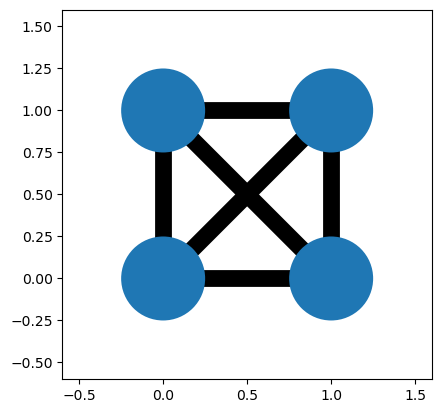

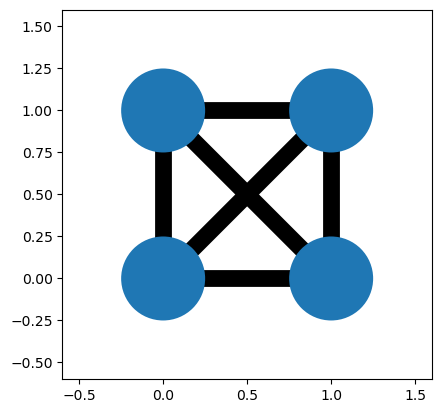

In [165]:

sys = hamiltonian(a, b, width, cell_scale, hops, phi, finite = True)

kwant.plot(sys, show = True)

## Infinite (translationally invariant) system
Now we define a system with translational invariance (infinite extent in the x-direction)

In [166]:
sys = hamiltonian(a, b, width, cell_scale, hops, phi, finite = False)

### Band Structure $E_{n}(k)$
The band structure is calculated with a call to the `kwant.physics.Bands` object. Calculating eigenenergies for a range of input momenta $|k| < \pi$

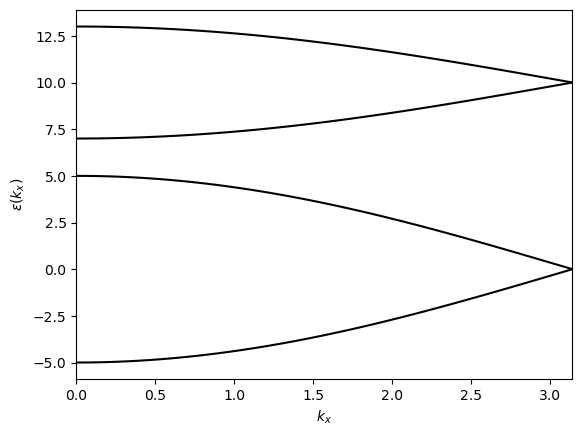

In [167]:
import numpy as np
import matplotlib.pyplot as plt

# Create and Bands object instance
bands = kwant.physics.Bands(sys)

# Calculate the band structure E_n(k)
momenta = np.linspace(0, np.pi, 50)
energies = [bands(k) for k in momenta]

# Plot the energies as a function of momenta
fig, band_ax = plt.subplots()
band_ax.plot(momenta, energies, color = 'k')
band_ax.set_xlim(0, np.pi)
band_ax.set_xlabel(r'$k_x$')
band_ax.set_ylabel(r'$\epsilon(k_x)$')
plt.show()

### Eigenstates $u_{nk}(\vec{r})$
Calculating the eigenstates is done in a similar manner. A call to `kwant.physics.Bands`, but returning the eigenvectors as well. Since this is an eigenvector of the unit cell alone, this is the function $u_{nk}(\vec{r})$

Momentum: 0
Eigenenergy 0: -5.00
Eigenstate 0: 
[[0.5-0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]

Eigenenergy 1: 5.00
Eigenstate 1: 
[[ 0.5+0.j  0.5+0.j]
 [-0.5+0.j -0.5+0.j]]

Eigenenergy 2: 7.00
Eigenstate 2: 
[[ 0.5+0.j -0.5+0.j]
 [ 0.5+0.j -0.5+0.j]]

Eigenenergy 3: 13.00
Eigenstate 3: 
[[-0.5+0.j  0.5+0.j]
 [ 0.5+0.j -0.5+0.j]]



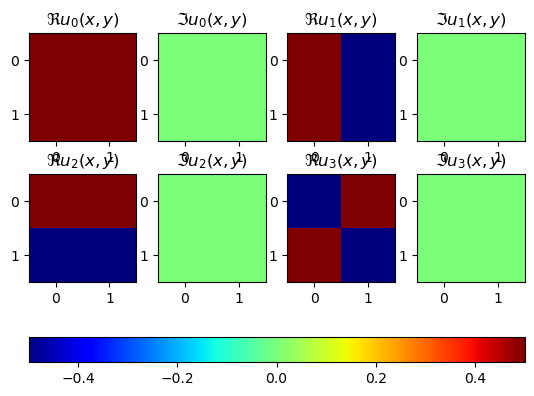

In [168]:
momenta = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi-0.001]

E_nk = []
u_nk = []
for kx in momenta:
    # Solve eigenvalue problem
    eigvals, eigvecs = bands(kx, return_eigenvectors = True)

    # N states will be the size of the last dimension of eigvecs
    N_states = np.size(eigvecs, 1)

    # Split the eigvec array so x is indexed directly
    eigvecs = np.array_split(eigvecs[:,:], cell_scale)
    
    # Append to total energy/state arrays
    E_nk.append(eigvals)
    u_nk.append(eigvecs)

# NumPy arrays, rearrange u_nk for clarity
E_nk = np.array(E_nk)
u_nk = np.array(u_nk)
u_nk = np.moveaxis(u_nk, 0, 2)
# Now u_nk shape: (x, y, N_k, N_states)

# Take a look at the first few eigenvectors for k=0
fig = plt.figure()
ax_unk = []
ki = 0
print('Momentum: {}'.format(momenta[ki]))
for n in range(N_states):
    energy = E_nk[0, n]
    state = u_nk[:, :, 0, n]
    
    print('Eigenenergy {}: {:3.2f}'.format(n, energy))
    print('Eigenstate {}: \n'.format(n) + str(state) + '\n')

    ax_re = fig.add_subplot(2, N_states, 2*n+1)
    ax_im = fig.add_subplot(2, N_states, 2*n+2)
    

    ax_re.set_title('$\Re u_{}(x,y)$'.format(n, kx))
    ax_im.set_title('$\Im u_{}(x,y)$'.format(n, kx))
    plot_unk = ax_re.imshow(np.real(state).transpose(), vmin=-0.5, vmax = 0.5, cmap = 'jet')
    plot_unk = ax_im.imshow(np.imag(state).transpose(), vmin=-0.5, vmax = 0.5, cmap = 'jet')

    ax_unk.append(ax_re)
    ax_unk.append(ax_im)

fig.colorbar(plot_unk, ax = ax_unk[:], location = 'bottom')
plt.show()


### Bloch states
Now that we have the $u_{nk}(\vec{r})$ for a single unit cell, we may construct the Bloch states for the infinite system as
$$\begin{equation}
\Psi_{nk}(\vec{r}) = e^{i\vec{k}\cdot\vec{r}}u_{nk}(\vec{r})
\end{equation}$$
where we take $k_y = 0$ so we have $\vec{k} = k_x$ and we calculate
$$\begin{equation}
\Psi_{nk}(x,y) = e^{ik_x x}u_{nk}(x,y)
\end{equation}$$

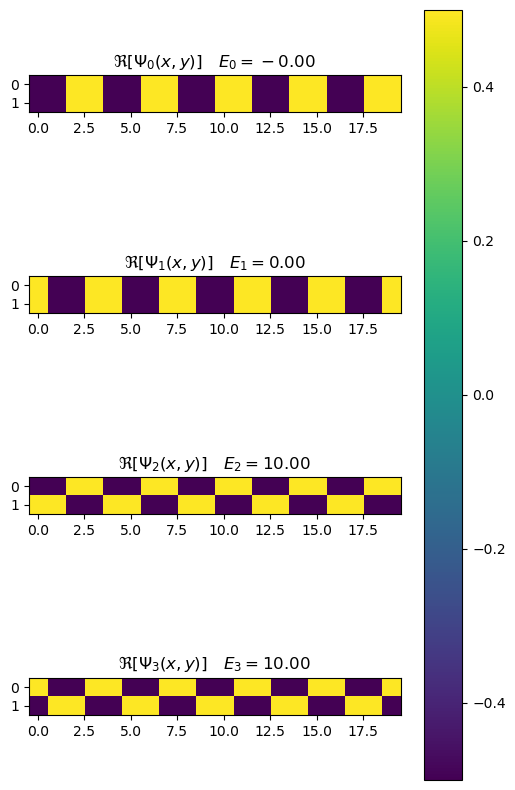

In [178]:
# Extend the u_nk over an arbitrary range in the x-direction
# u_nk shape: (N_momenta, N_x, N_y, N_states)
N = 10
U_nk = []
for _ in range(N):
    for xi in range(cell_scale):
        U_nk.append(u_nk[xi, :, :, :])
U_nk = np.array(U_nk)

# Calculate the Bloch states by modulating u_nk with a plane wave
psi_nk = [[] for _ in range(len(momenta))]
for ki, k in enumerate(momenta):
    k = k/cell_scale
    for ni in range(N):
        for xi in range(cell_scale):
            x = xi + cell_scale*ni
            psi_nk[ki].append(np.exp(1j*k*x) * U_nk[x, :, ki, :])
psi_nk = np.array(psi_nk)
psi_nk = np.swapaxes(psi_nk, 0, 1)
psi_nk = np.swapaxes(psi_nk, 1, 2)

fig = plt.figure(figsize = (6,10))
ax_psi = []
for n in range(4):
    ax = fig.add_subplot(4,1,n+1)

    ax.set_title('$\Re[\Psi_{}(x,y)] \quad E_{} = {:3.2f}$'.format(n, n, eigvals[n]))
    plot_psi = ax.imshow(psi_nk[:,:,4,n].real.transpose(), vmin=-0.5, vmax = 0.5)
    ax_psi.append(ax)

fig.colorbar(plot_psi, ax = ax_psi[:], location = 'right')
plt.show()
    